# Academic success in high schools: What factors influence differences in SAT performance across New York City?

## Abstract 

The SAT is a standardized test widely used for college admissions in the United States. The goal of this project was to identify any unintended patterns that would put certain groups at an disadvantage. This is an important step in making the US education system more equal for all. According the US Department of Education website, the challenge of ensuring educational equity is formidable. 

In hopes to be more informed on this matter, I would like to know:

1. What factors influence differences in SAT scores and opportunities to attend certain colleges/universities? 
2. Factoring in housing prices, where can one get the best high school education in New York City?
3. Using crime and US Household median income data to back up the safety scores 

## Methods

This analysis used descriptive statistics and data vizualizations to explore the following datasets on New York City high schools.

1. Sat scores for all NYC high schools in 2011-2012
2. School attendance information 
3. Class size 
4. Advanced Placement (AP) test results - only select schools offered AP curriculum  
5. Demographic information 
6. Graduation outcome 
7. NYC Housing Data 
8. NYC Crime Data 


The extract, transform, and load (ETL) portion was done as part of dataquests instructions and methodology. 



# ETL

In [1]:
#Libraries used for analysis and visualizations 

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import folium
import branca.colormap as cm
import cufflinks as cf  # interactive plotting made easy (pandas style)

# Using plotly + cufflinks in offline mode
from plotly.offline import iplot, init_notebook_mode
cf.go_offline(connected=True)
init_notebook_mode(connected=True)


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\alao8\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




# Add DBN columns

In [3]:
# add DBN columns as unique identifier in datasets where they are not yet present

data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
# summing SAT-score
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]




def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
# selecting the classes relevant for SAT-analysis (high school, general education)
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# select most recent data available in "demographics" and "graduation" dataset
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]
# left joins for somewhat sparse datasets, because we do not want to lose any SAT-info
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

# inner joins for other dataset that potentially contain very relevant explanatory features.
to_merge = ["class_size", "demographics", "survey", "hs_directory"]
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")
    
#missing values for numeric columns filled with mean, non-numerics with zeros 
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
# Add a school district column for later analysis
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Correlation between School Safety Score and Sat Scores

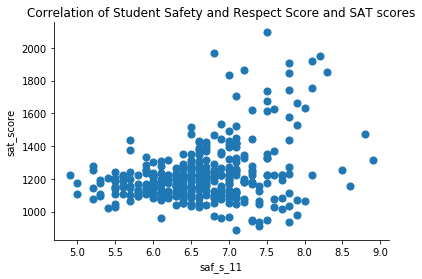

In [11]:
%matplotlib inline
ax = combined.plot.scatter(x = 'saf_s_11', y = 'sat_score',s=50, zorder =2, title= 'Correlation of Student Safety and Respect Score and SAT scores')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so. Unsafe environments could negatively influence good SAT performance.

In [12]:
by_district = combined.groupby("school_dist").mean().reset_index()


#Set up base map 
nyc_school_map = folium.Map(location=[40.693943, -73.985880],
                           zoom_start = 10,
                           tiles= 'openstreetmap')
map_title = "Safety and Respect Score and Average SAT Scores by NYC School Districts"
title_html = '''
            <h3 align="center" style="font-size:20px"><b>{}</b></h3>
            '''.format(map_title)

nyc_school_map.get_root().html.add_child(folium.Element(title_html))

#column names to be used 
size_param = 'sat_score'
color_param = 'saf_s_11'

start_val = by_district[color_param].min()
end_val = by_district[color_param].max()
start_color = "#de2d26"
end_color = "#31a354" 

color_map = cm.LinearColormap(colors=[start_color,
                                     end_color],
                             vmin=start_val,
                             vmax=end_val
                            )
color_map.caption = "Safety and Respect Score, students response"

for index, row in by_district.iterrows():
    folium.Circle(location=[row["lat"],row["lon"]],
                  color=color_map(row[color_param]),
                  fill_color=color_map(row[color_param]),
                  fill_opacity=0.75,
                  radius=row[size_param],
                  weight=2,
                  tooltip="District "+row["school_dist"]+
                      " <br> Avg. Safety / Respect Score, students response (color): {:.1f}".format(row[color_param])+
                      " <br> Avg. SAT Scores (size): {:.0f}".format(row[size_param])
                 ).add_to(nyc_school_map)

nyc_school_map.add_child(color_map)
nyc_school_map

Looks like part of Bronx and Upper Brooklyn report low Safety/Response, student responses. As seen in the scatterplot, there is correlation between good SAT scores and high Safety/Response, student responses. 

# Correlation between survey responses and SAT scores

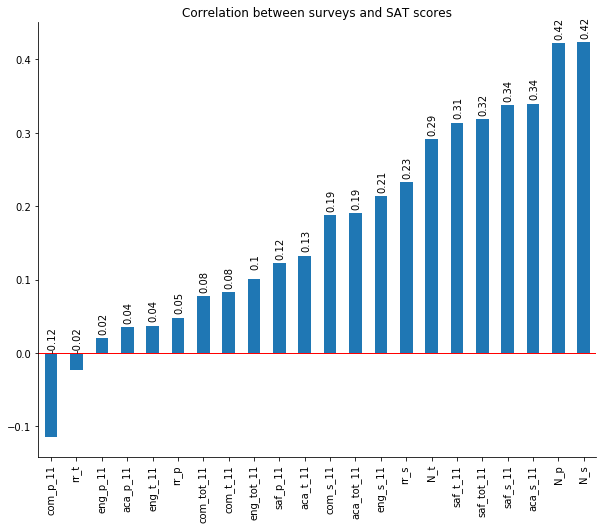

In [13]:
#correlation of SAT scores 
correlations = combined.corr()['sat_score']

#create a bar chart 

ax = correlations[survey_fields].sort_values().plot(kind= 'bar', figsize = (10,8), title = 'Correlation between surveys and SAT scores')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#create a horizontal line to readability purposes 
ax.axhline(y=0.0, color='red', linestyle='-', linewidth=1)

#values on each bar 

for i in ax.patches:
    ax.annotate(str(round(i.get_height(),2)),
               (i.get_x()+0.1, max(i.get_height(),0)+ 0.025), rotation=90)

Safety and Respect (saf_s_11 ~0.34) and student academic expectations (aca_s_11 ~0.34) have a moderate correlation with good SAT scores. It's also important to note the teachers' safety and respect score (saf_t_11 ~ 0.29) is relevant with good SAT scores. Overall, it makes sense when students and teachers feel safe and have trusting relationships, they can focus on providing a positive environment to achieve better academic results.

# Racial Differences in SAT Scores: Blacks and Hispanics are at high disadvantage. 

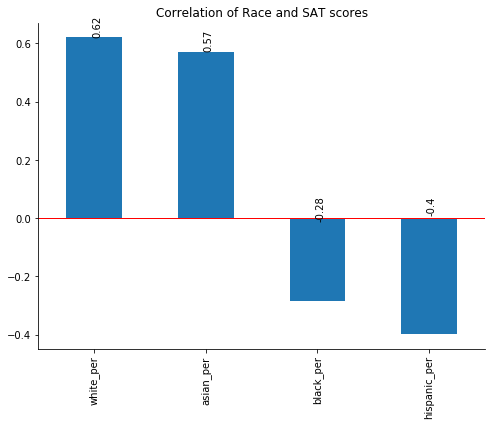

In [14]:
race_fields= ['white_per', 'asian_per', 'black_per', 'hispanic_per']

ax = combined.corr()['sat_score'][race_fields].plot(kind= 'bar', figsize=(8,6), title='Correlation of Race and SAT scores')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#create a horizontal line to readability purposes 
ax.axhline(y=0.0, color='red', linestyle='-', linewidth=1)

#values on each bar 

for i in ax.patches:
    ax.annotate(str(round(i.get_height(),2)),
               (i.get_x()+0.23, max(i.get_height(),0)+ 0.05), rotation=90)

White and Asian students have a significant positive correlations with SAT scores, whereas  Black and Hispanic students have negative correlations with Hispanics being at a slightly higher disadvantage. This trends in the NYC dataset are in agreement with the achievement gaps among groups of students in the same time period (2011).  https://nces.ed.gov/nationsreportcard/studies/gaps/ 

In [15]:
combined.iplot(
        x='hispanic_per',
        y='sat_score',
        categories='boro',
        text="SCHOOL NAME",
        vline= {"x":combined["hispanic_per"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":combined["sat_score"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Share hispanics, %',
        yTitle='Avg. SAT score',
        title='Hispanic students vs. SAT score by school <br> Dashed lines: Averages of each parameter'
    )
print("Recommendation: Click the legend to view by boroughs")


Recommendation: Click the legend to view by boroughs


1. Schools with low average SAT scores and high percentages of hispanic students are often named "International". These schools specialize on students with limited English skills thus these schools tend to score below average because the SAT tests both reading and writing.


2. Schools with high average SAT scores and low percentages of hispanics are highly selective ('technical') public schools with prestigious reputations. Here's a list of schools from each borough with avg SAT > 1800:
            Manhattan - Stuyvesant High School, Bard High School Early College
            Bronx - Bronx High School and High School of American Studies at Lehman College 
            Brooklyn - Brooklyn Technical School
            Queens - Queens High School for the Sciences at York College and Townsend Harris High School 
            Staten Island - Staten Island Technical High School
            
            
This brings up another question of interest. Out of these high-performing schools (avg. SAT > 1800), what are the demographics?

In [16]:
elite = combined[(combined['hispanic_per'] > 10) & (combined['sat_score'] > 1800)]
elite

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\r\nNew York, NY 10002\...",40.718962,-73.976066,01
79,05M692,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",101,605.0,654.0,588.0,1847.0,HIGH SCHOOL FOR MATH SCIENCE ENGINEERING @ CCNY,114.000000,124.000000,...,0,0,0,0,0,0,"240 Convent Ave\r\nNew York, NY 10031\r\n(40.8...",40.821123,-73.948845,05
155,10X696,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,92,636.0,648.0,636.0,1920.0,HIGH SCHOOL OF AMERICAN STUDIES At Lehman College,194.000000,302.000000,...,0,0,0,0,0,0,"2925 Goulden Avenue\r\nBronx, NY 10468\r\n(40....",40.871255,-73.897516,10
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\r\nFlushing, NY 11367\...",40.734408,-73.821417,25


In [17]:

#List of the racial makeups
num_race = ['asian_num', 'black_num', 'hispanic_num', 'white_num']

#Filter out schools with 'Elite' Sat Scores (> 1800)
high_sat_scores = combined["sat_score"] > 1800

#Create a dateframe, aggregating the sum of each race, average SAT scores by race
race_dist = pd.DataFrame(data=[combined.loc[:, num_race].sum()/combined.loc[:, num_race].sum().sum(),
                               combined.loc[high_sat_scores , num_race].sum()/combined.loc[high_sat_scores , num_race].sum().sum()],
                         index=["All schools", "Elite schools"])*100

#Create the appropriate columns
race_dist.columns = ["Asian","Black","Hispanic", "White"]

#Stacked bar to analyze demographic of students in these high average SAT scores 
race_dist.astype(int).iplot(kind="bar", barmode="stack", yTitle='Share of all students in %',
                            title='Demographic of NYC High Schools, <br> All vs. Elite (Avg. SAT score > 1,800)')

Blacks and hispanics are underrepresented in 'Elite Schools' whereas asians and whites are overrepresented. This could be attributed to certain groups having access to more resources.

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Gender Differences in SAT Scores

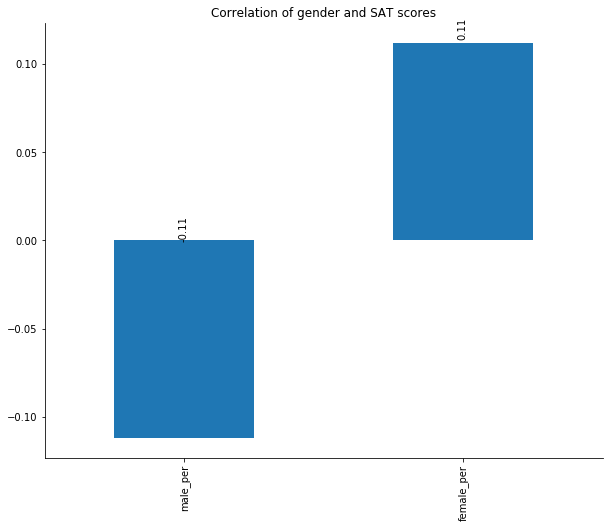

In [18]:
gender_fields = ['male_per', 'female_per']

ax = combined.corr()['sat_score'][gender_fields].plot.bar(figsize = (10,8), title = 'Correlation of gender and SAT scores')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i in ax.patches:
    ax.annotate(str(round(i.get_height(),2)),
               (i.get_x()+0.23, max(i.get_height(),0)+ 0.0095), rotation=90)

In the plot above, we can see that females have a positive correlation with SAT scores, whereas males have a negative correlation. However, neither correlation is extremely strong.

In [19]:
combined.iplot(
        x='female_per',
        y='sat_score',
        categories='boro',
        text="SCHOOL NAME",
        vline= {"x":combined["female_per"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":combined["sat_score"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Share females, %',
        yTitle='Avg. SAT score',
        title='Female students vs. SAT score by school <br> Dashed lines: Averages of each parameter'
    )
print("Recommendation: Click the legend to view by boroughs")


Recommendation: Click the legend to view by boroughs


In [20]:
a = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1400)]['SCHOOL NAME']

a

5                         BARD HIGH SCHOOL EARLY COLLEGE
22              PROFESSIONAL PERFORMING ARTS HIGH SCHOOL
26                         ELEANOR ROOSEVELT HIGH SCHOOL
27                                MILLENNIUM HIGH SCHOOL
40                          TALENT UNLIMITED HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
287                    BARD HIGH SCHOOL EARLY COLLEGE II
302                          TOWNSEND HARRIS HIGH SCHOOL
325    QUEENS GATEWAY TO HEALTH SCIENCES SECONDARY SC...
342         FRANK SINATRA SCHOOL OF THE ARTS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

1. These schools appears to be very selective liberal arts schools that have high academic standards.

2. Only Manhattan and Queens high schools have > 60% female and scored above 1400. Females in the remaining boroughs may have limited access to good education. If we reduced female  % to 50 and kept > 1400 SAT Scores, it would only return 4 more schools in Brooklyn. 

3. More than 50% of schools in Brooklyn and Bronx fall under the average SAT score (~1200).

In [21]:
combined.iplot(
        x='male_per',
        y='sat_score',
        categories='boro',
        text="SCHOOL NAME",
        vline= {"x":combined["male_per"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":combined["sat_score"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Share males, %',
        yTitle='Avg. SAT score',
        title='Male students vs. SAT score by school <br> Dashed lines: Averages of each parameter'
    )
print("Recommendation: Click the legend to view by boroughs")


Recommendation: Click the legend to view by boroughs


In [22]:
a = combined[(combined['male_per'] > 60) & (combined['sat_score'] > 1400)]['SCHOOL NAME']
a

79    HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
Name: SCHOOL NAME, dtype: object

1. There was only one high school in all of the boroughs that had > 60% males and scored above 1400: High School for Mathematics, Science, and Engineering at City College in Manhattan.

2. Similar to the female vs avg. SAT score plot, more than 50% of schools in Bronx and Brooklyn fall below the average SAT (~1200).

# AP Exam Scores and SAT Score 

In [23]:
combined['ap_per'] = (combined['AP Test Takers ']/combined['total_enrollment'])*100


In [24]:
combined.iplot(
        x='ap_per',
        y='sat_score',
        categories='boro',
        text="SCHOOL NAME",
        vline= {"x":combined['ap_per'].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":combined['sat_score'].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='AP Takers, %',
        yTitle='Avg. SAT score',
        title='Advanced Placement (AP) Takers, % vs. SAT score by school <br> Dashed lines: Averages of each parameter'
    )
print("Recommendation: Click the legend to view by boroughs")

Recommendation: Click the legend to view by boroughs


Advanced Placement (AP) is a program in the United States and Canada created by the College Board which offers college-level curricula and examinations to high school students. American colleges and universities may grant placement and course credit to students who obtain high scores on the examinations. 


1. With SAT above 1400, there is a linear correlation between the AP Takers % and SAT scores. Upon more research, the school had high enrollments standards. Thus, students with higher academia would benefit more from these AP classes than other school. 


2. It's suprising to see schools with high shares of AP takers exhibited near or equal the average SAT score. This draws another questions to why these schools exhibit such poor SAT scores given the high share of AP takers. We can use the Z-Score to determine which factors attribute more. The Z-Score represents, for a given value x of your numerical variable distribution, “how many standard deviations” it is from your variable mean. If Z-Score is positive, then your x value is above the mean. On the other hand, if your Z-Score is negative, then your x value is below that mean.

Otherwise, a high share of AP takers does not indicate a strong SAT score. 

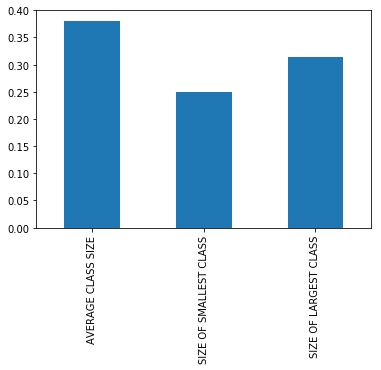

In [25]:
class_size = ['AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS']
combined.corr()['sat_score'][class_size].plot.bar()

In [26]:
# first select schools for comparison, 25-50% of AP Takers and below the average:
high_ap_low_sat = combined[(combined["ap_per"]>25)&
                            (combined["ap_per"]<50) &
                            (combined["sat_score"] < 1300)]

high_ap_high_sat = combined[(combined["ap_per"]>25)&
                            (combined["ap_per"]<50)&
                            (combined["sat_score"]>1300)]


# define loop trough subsets and extract relative distribution of ap_courses
subsets = {"High AP, low SAT": high_ap_low_sat,
           "High AP, high SAT": high_ap_high_sat}
subsets_ap_courses = pd.DataFrame()

#Loop to split the course strings and reshaped the dataframe to a longer format
for k, v in subsets.items():
    ap_courses = v["advancedplacement_courses"].str.split(",",expand=True)
    ap_courses_melted = ap_courses.melt()["value"].str.strip().value_counts(normalize=True).sort_values()
    ap_courses_melted.name = k
    subsets_ap_courses = pd.concat([subsets_ap_courses, ap_courses_melted], axis=1, sort=True)

# Plot bar graph of offered AP courses 
ax = (subsets_ap_courses*100).iplot(kind="bar", 
                            #figsize=(10,7), 
                            layout = dict(title="AP Subject Matters, normalized count in %",
                                          xaxis=dict(automargin=True), hovermode="x", height=600, width=1000))

Schools with high share of AP takers and low SATs offer a limited selection of courses. They mainly focus on history and literature; surprisingly English literature and composition is highly enrolled. 

# NYC Housing Data 

Read-in property sales data from 'NYC Open Data'-server following API documentation found on: https://dev.socrata.com/foundry/data.cityofnewyork.us/5ebm-myj7

In [27]:
from sodapy import Socrata

housing_data = Socrata("data.cityofnewyork.us", None)
df = pd.DataFrame.from_records(housing_data.get("5ebm-myj7", limit=6000))

df.head()

,average_sale_price,borough,highest_sale_price,lowest_sale_price,median_sale_price,neighborhood,number_of_sales,type_of_home,year
0,593362,MANHATTAN,593362.00,593362,593362,ALPHABET CITY,1,01 ONE FAMILY HOMES,2010
1,1320000,MANHATTAN,1320000.00,1320000,1320000,ALPHABET CITY,1,02 TWO FAMILY HOMES,2010
2,900000,MANHATTAN,900000.00,900000,900000,ALPHABET CITY,1,03 THREE FAMILY HOMES,2010
3,2875000,MANHATTAN,5250000.00,500000,2875000,CHELSEA,2,01 ONE FAMILY HOMES,2010
4,2603107,MANHATTAN,3900000.00,1306213,2603107,CHELSEA,2,02 TWO FAMILY HOMES,2010


In [28]:
df.isnull().sum()

average_sale_price    0
borough               0
highest_sale_price    0
lowest_sale_price     0
median_sale_price     0
neighborhood          1
number_of_sales       0
type_of_home          0
year                  0
dtype: int64

In [29]:
df.describe()

,average_sale_price,borough,highest_sale_price,lowest_sale_price,median_sale_price,neighborhood,number_of_sales,type_of_home,year
count,5979,5979,5979,5979,5979,5978,5979,5979,5979
unique,5625,5,2246,1588,2426,249,277,9,10
top,700000,BROOKLYN,1200000.00,200000,450000,SUNNYSIDE,1,01 ONE FAMILY HOMES,2013
freq,10,1673,53,712,58,57,546,1958,611


In [30]:
df.dtypes

average_sale_price    object
borough               object
highest_sale_price    object
lowest_sale_price     object
median_sale_price     object
neighborhood          object
number_of_sales       object
type_of_home          object
year                  object
dtype: object

In [31]:
#Need to change data types to numeric for analysis 

num_cols = df.loc[:,["number_of_sales", "year"]].columns.to_list()

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors = 'coerce')
    


In [32]:
#Check to confirm cols are the correct datatypes
df.dtypes

average_sale_price    object
borough               object
highest_sale_price    object
lowest_sale_price     object
median_sale_price     object
neighborhood          object
number_of_sales        int64
type_of_home          object
year                   int64
dtype: object

In [33]:
#Upon looking at te=ge home type, there are several iterations of 1,2, and 3 family homes. Let's write a function to consolidate in three types only.
df['type_of_home'].value_counts()

01 ONE FAMILY HOMES          1958
02 TWO FAMILY HOMES          1927
03 THREE FAMILY HOMES        1439
01 ONE FAMILY DWELLINGS       221
02 TWO FAMILY DWELLINGS       215
03 THREE FAMILY DWELLINGS     162
01  ONE FAMILY HOMES           23
02  TWO FAMILY HOMES           18
03  THREE FAMILY HOMES         16
Name: type_of_home, dtype: int64

In [34]:
def home_type(h):
    if "01" in h:
        return "One Family House"
    elif "02" in h:
        return "Two Family House"
    elif "03" in h:
        return "Three Family House"
    else:
        "Error occurred"
df['type_of_home'] = df['type_of_home'].apply(home_type)



In [35]:
#Vrtify that we consolidated into only three categories. 
home_types = df['type_of_home'].value_counts()

In [39]:
df.describe()

,average_sale_price,number_of_sales,year
count,5.979000e+03,5979.000000,5979.000000
mean,1.207115e+06,35.560462,2014.520990
std,1.989597e+06,50.761453,2.860365
min,1.675000e+05,1.000000,2010.000000
25%,4.535140e+05,5.000000,2012.000000
50%,6.240080e+05,16.000000,2015.000000
75%,9.626070e+05,46.000000,2017.000000
max,2.689300e+07,519.000000,2019.000000


Text(0.5, 0, 'Borough')

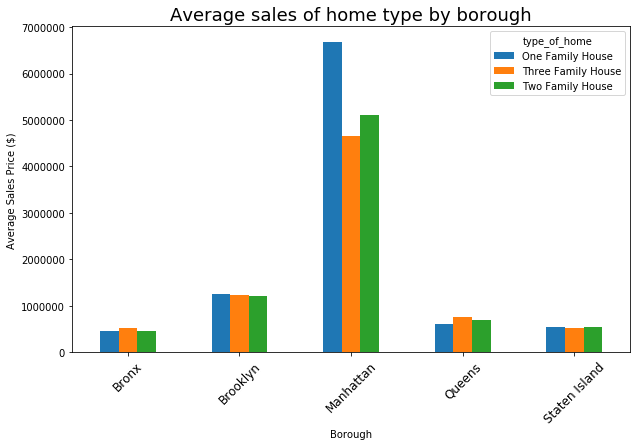

In [37]:
#Changed object to int for analysis 
df['average_sale_price'] = df['average_sale_price'].astype(int)

avg_price_borough = df.pivot_table(columns='type_of_home', index='borough', values="average_sale_price", aggfunc= np.mean)
ax = avg_price_borough.plot(kind='bar', title="Average sales of home type by borough", figsize=(10,6))

ax.set_title('Average sales of home type by borough',fontsize= 18) # title of plot

ax.set_xticklabels(labels = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"],rotation=45, fontsize=12) # Adjusted tick labels 
ax.set_ylabel("Average Sales Price ($)", fontsize=10)
ax.set_xlabel("Borough", fontsize=10)

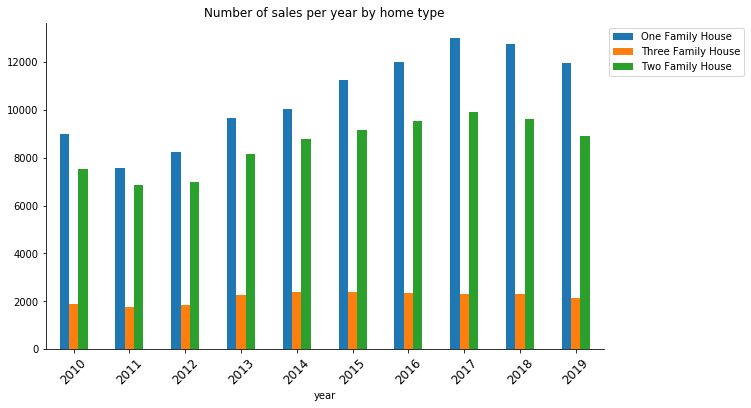

In [38]:
# Used pivot_table to create multi index so we want to access the number of sales per year of each house hold type 

pivot = df.pivot_table(columns='type_of_home', index='year', values="number_of_sales", aggfunc= sum)

#Used Seaborn library for visualizations 

ax = pivot.plot(kind='bar', title="Number of sales per year by home type", figsize=(10,6))
ax.set_xticklabels(labels = ["2010", "2011","2012","2013","2014","2015","2016","2017","2018","2019",],rotation=45, fontsize=12) # Adjusted tick labels 

#Edit the spines for better visibility 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#Move the legend off the graph for better visuals
plt.legend(bbox_to_anchor=(1,1))
plt.show()

To no surprise, 1 family homes are the most common types of property sold. 

In [60]:
# calculate average price per neighborhood
ofh_price = df.groupby(["neighborhood"]).mean().reset_index().drop(columns=["year","number_of_sales"])
ofh_price.rename(inplace=True, columns={"average_sale_price":"avg_sale_price"})


# calculate average number of sales per year per neighborhood

ofh_num_sales = df.groupby(["neighborhood"]).sum().reset_index().drop(columns=["year","average_sale_price"])
ofh_num_sales["sales_per_year"] = ofh_num_sales["number_of_sales"]/len(df["year"].unique())
ofh_num_sales.drop(inplace=True,columns="number_of_sales")

# Merge the two Series 
ofh = pd.merge(left=ofh_price, right=ofh_num_sales, on="neighborhood", indicator=True)
ofh.head()

,neighborhood,avg_sale_price,sales_per_year,_merge
0,AIRPORT LA GUARDIA,6.674923e+05,2.8,both
1,ALPHABET CITY,3.580997e+06,1.4,both
2,ANNADALE,6.818096e+05,99.4,both
3,ARDEN HEIGHTS,4.553873e+05,171.4,both
4,ARROCHAR,4.997203e+05,17.4,both


In [63]:
# generate histogram for sales per year
ofh["avg_sale_price"].iplot(kind="histogram", asFigure=True, bins=50, 
                            title="Count of the average price of one family house",xTitle='Average price, USD', yTitle='Count')

# Reverse geocoding for insightful location features 

[Reverse geocoding](https://towardsdatascience.com/reverse-geocoding-in-python-a915acf29eb6) is the process of back (reverse) coding of a point location (latitude, longitude) to a readable address or place name. Here's the [documenation](https://blog.batchgeo.com/new-feature-reverse-geocoding/)

In [45]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

combined['Coordinates'] = combined['lat'].astype(str) + "," + combined['lon'].astype(str)

# read documentation https://geopy.readthedocs.io/

locater = Nominatim(user_agent="geo_for_nyc_housing", timeout=10)


# adding RateLimiter to reduce the load on Geoservice 

rev_geocode = RateLimiter(locater.reverse, min_delay_seconds=0.2)


combined['rev_geocode'] = combined['Coordinates'].apply(rev_geocode)

In [46]:
combined['rev_geocode'] 

0      (Corlears Junior High School, Henry Street, Tw...
1      (University Neighborhood High School, 200, Mon...
2      (402, East 12th Street, East Village, Manhatta...
3      (Lower East Side Preparatory High School, 145,...
4      (New Explorations into Science Technology and ...
5      (Bard High School Early College, 525, East Hou...
6      (School of Visual Arts, East 23rd Street, Gram...
7      (517, West 50th Street, Hell's Kitchen, Manhat...
8      (350, Grand Street, Lower East Side, Manhattan...
9      (517, West 50th Street, Hell's Kitchen, Manhat...
10     (94, Hester Street, Chinatown, Manhattan, Manh...
11     (517, West 50th Street, Hell's Kitchen, Manhat...
12     (517, West 50th Street, Hell's Kitchen, Manhat...
13     (350, Grand Street, Lower East Side, Manhattan...
14     (350, Grand Street, Lower East Side, Manhattan...
15     (HSBC, 26, Broadway, Financial District, Manha...
16     (40, Irving Place, Union Square, Manhattan Com...
17     (Broome Street, SoHo, Hu

In [52]:
#Use list comprhensions to pull location objects from reverse geo code dictionary 
combined['rev_geo_raw'] = [x.raw for x in combined['rev_geocode']]
combined['address_dict'] = [x.get("address") for x in combined['rev_geo_raw']]
combined['neighborhood'] = [x.get("neighbourhood") for x in combined['address_dict']]
combined['suburb_name'] = [x.get('surburb') for x in combined['address_dict']]


combined.head(10)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,lat,lon,school_dist,ap_per,Coordinates,rev_geocode,rev_geo_raw,address_dict,neighborhood,suburb_name
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,40.713764,-73.985260,01,30.575556,"40.71376394700047,-73.98526003999967","(Corlears Junior High School, Henry Street, Tw...","{'place_id': 171820028, 'licence': 'Data © Ope...","{'amenity': 'Corlears Junior High School', 'ro...",Two Bridges,None
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,40.712332,-73.984797,01,9.898477,"40.7123318510005,-73.98479662499966","(University Neighborhood High School, 200, Mon...","{'place_id': 152520497, 'licence': 'Data © Ope...",{'amenity': 'University Neighborhood High Scho...,Lower East Side,None
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,40.729783,-73.983041,01,3.177258,"40.72978268700047,-73.98304144099967","(402, East 12th Street, East Village, Manhatta...","{'place_id': 146156216, 'licence': 'Data © Ope...","{'house_number': '402', 'road': 'East 12th Str...",East Village,None
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,40.720569,-73.985673,01,35.157724,"40.72056907900048,-73.98567269099966","(Lower East Side Preparatory High School, 145,...","{'place_id': 235924867, 'licence': 'Data © Ope...",{'building': 'Lower East Side Preparatory High...,Lower East Side,None
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,40.718725,-73.979426,01,15.809051,"40.71872545100047,-73.97942638599966",(New Explorations into Science Technology and ...,"{'place_id': 121160849, 'licence': 'Data © Ope...",{'amenity': 'New Explorations into Science Tec...,Lower East Side,None
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,40.718962,-73.976066,01,20.912293,"40.71896161700045,-73.97606602099967","(Bard High School Early College, 525, East Hou...","{'place_id': 121768242, 'licence': 'Data © Ope...","{'amenity': 'Bard High School Early College', ...",Lower East Side,None
6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395.0,400.0,387.0,1182.0,0,129.028846,197.038462,...,40.738599,-73.982512,02,74.154509,"40.73859908700047,-73.98251191099969","(School of Visual Arts, East 23rd Street, Gram...","{'place_id': 233493283, 'licence': 'Data © Ope...","{'amenity': 'School of Visual Arts', 'road': '...",Gramercy,None
7,02M288,FOOD AND FINANCE HIGH SCHOOL,62,409.0,393.0,392.0,1194.0,0,129.028846,197.038462,...,40.765027,-73.992517,02,29.798810,"40.765026708000455,-73.99251657799965","(517, West 50th Street, Hell's Kitchen, Manhat...","{'place_id': 28206636, 'licence': 'Data © Open...","{'house_number': '517', 'road': 'West 50th Str...",Hell's Kitchen,None
8,02M294,ESSEX STREET ACADEMY,53,394.0,384.0,378.0,1156.0,0,129.028846,197.038462,...,40.716867,-73.989532,02,37.617739,"40.71686722400045,-73.98953194299962","(350, Grand Street, Lower East Side, Manhattan...","{'place_id': 148425242, 'licence': 'Data © Ope...","{'house_number': '350', 'road': 'Grand Street'...",Lower East Side,None
9,02M296,HIGH SCHOOL OF HOSPITALITY MANAGEMENT,58,374.0,375.0,362.0,1111.0,High School of Hospitality Management,129.028846,197.038462,...,40.765027,-73.992517,02,30.794474,"40.765026708000455,-73.99251657799965","(517, West 50th Street, Hell's Kitchen, Manhat...","{'place_id': 28206636, 'licence': 'Data © Open...","{'house_number': '517', 'road': 'West 50th Str...",Hell's Kitchen,None


In [56]:
# There 18 records with missing information. We will replace any missing neighborhood with the suburb name 
combined["neighborhood"] = combined["neighborhood"].fillna(combined["suburb_name"])
combined["neighborhood"] = combined["neighborhood"].fillna(0)

print ("impute {} missing neighborhoods from suburb".format(combined["neighborhood"].isna().sum()))
print ("{} missing neighborhoods remaining and filled with '0'".format(combined["neighborhood"].isna().sum()))


impute 0 missing neighborhoods from suburb
0 missing neighborhoods remaining and filled with '0'


In [69]:
# drop dict, geocode, and geo raw column because they are not needed anymore
combined_incl_locations = combined.copy() # but we will keep them in backup df because API call duration
combined.drop(columns=["rev_geocode","rev_geo_raw","address_dict"])

# to successfully merge the dataframe, we must change the formatting of neighborhoods
ofh['neighborhood'] = ofh['neighborhood'].str.lower().str.strip()
combined['neighborhood'] = combined['neighborhood'].str.lower().str.strip()

In [71]:
ofh['neighborhood'] 

0            airport la guardia
1                 alphabet city
2                      annadale
3                 arden heights
4                      arrochar
5          arrochar-shore acres
6                       arverne
7                       astoria
8                    bath beach
9                      bathgate
10                    bay ridge
11                   baychester
12                      bayside
13         bedford park/norwood
14           bedford stuyvesant
15                   beechhurst
16                 belle harbor
17                    bellerose
18                      belmont
19                  bensonhurst
20                 bergen beach
21                   bloomfield
22                  boerum hill
23                 borough park
24                 breezy point
25                    briarwood
26               brighton beach
27                broad channel
28                   bronx park
29                    bronxdale
                 ...           
219     

In [73]:
combined['neighborhood'] 

0             two bridges
1         lower east side
2            east village
3         lower east side
4         lower east side
5         lower east side
6                gramercy
7          hell's kitchen
8         lower east side
9          hell's kitchen
10              chinatown
11         hell's kitchen
12         hell's kitchen
13        lower east side
14        lower east side
15     financial district
16           union square
17                   soho
18                chelsea
19         hell's kitchen
20           union square
21                midtown
22         hell's kitchen
23                    NaN
24                chelsea
25                chelsea
26        upper east side
27     financial district
28                chelsea
29               gramercy
              ...        
333             laurelton
334             laurelton
335                hollis
336       cambria heights
337       cambria heights
338               astoria
339      long island city
340         

In [76]:
# now finally add property data to school dataset
combined_ofh = pd.merge(left=combined, right=ofh, on="neighborhood",how="left")
share_prop = 100-combined_ofh["avg_sale_price"].isna().sum()/combined_ofh.shape[0]*100
print("{:,.0f}% of schools have property values associated with them".format(share_prop))

40% of schools have property values associated with them


In [91]:
combined_ofh = combined_ofh[combined_ofh['avg_sale_price'].notna()]

combined_ofh.shape # 144 rows and 170 columns 

#Since the merge we have 170 columns, we only want to include the cols critical for analysis 
analysis_df = combined_ofh.loc[:, ["neighborhood", "boro", "sat_score", "avg_sale_price",'saf_tot_11']]

#let's group by bourough and neighborhood and take the mean of the SAT, AVG Price of a One Family Home, and Safety/Respect Score 
avg_borough = analysis_df.groupby(['boro','neighborhood']).mean().reset_index()

# Create a new column for detailed hover information 
avg_borough['hover_info'] = avg_borough['neighborhood'].str.title() + " | Avg. Safety/Respect Score: " + avg_borough['saf_tot_11'].round(1).astype(str)

#Round each of the columns for better analysis 
avg_borough['sat_score'] = avg_borough['sat_score'].round().astype(int)
avg_borough['avg_sale_price'] = avg_borough['avg_sale_price'].round().astype(int)

avg_borough.head()

,boro,neighborhood,sat_score,avg_sale_price,saf_tot_11,hover_info
0,Bronx,belmont,1140,431974,7.166667,Belmont | Avg. Safety/Respect Score: 7.2
1,Bronx,bronxdale,1268,435064,7.300000,Bronxdale | Avg. Safety/Respect Score: 7.3
2,Bronx,co-op city,1142,401143,7.200000,Co-Op City | Avg. Safety/Respect Score: 7.2
3,Bronx,east tremont,1148,413358,7.500000,East Tremont | Avg. Safety/Respect Score: 7.5
4,Bronx,fordham,1190,448843,7.500000,Fordham | Avg. Safety/Respect Score: 7.5


In [92]:

avg_borough.iplot(
        x = 'avg_sale_price',
        y = 'sat_score',
        categories = 'boro',
        text = 'hover_info',
        vline= {"x":avg_borough['avg_sale_price'].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":avg_borough['sat_score'].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        layout = dict(
            hovermode="closest",
            title='Property value vs. SAT score by neighborhood'),
            xTitle='Avg. value of one family home, $',
            yTitle='Avg. SAT score'

)